# Notebook evaluating metrics for particular node/edge configuration

In [5]:
# If new server on Descartes Labs, need to install rioxarray 
try: import rioxarray
except: 
    %pip install rioxarray
    
# Import helper functions
import imports as ip
import netconf as nc
import plotting as pl
import helper_functions as hf

In [6]:
## Define variables
# Label imports
buildingFile = "./data/beirutBuildingFootprints.geojson" # OSM data
assessmentFile = "./data/geopalData.csv" # GeoPal data
bourjData = "./data/bourjHammoud.csv" # GeoPal Extra
manualData = "./data/manualDamageClasses.csv" # GeoPal manual data
crs = 'epsg:4326' # Coordinate system
cn = 'decision' # Column for classes
splitString = True # Only use first word in class column
confidence = [0, 1] # Confidence in a priori labels (other classes, specified class)

# Data imports
dataTypes = ['ifg']
ifgPreFile = "./data/beirutPrePreExplosionIfg.tif" # SNAP output 1
ifgPostFile = "./data/beirutPrePostExplosionIfg.tif" # SNAP output 2
ifgBoth = False # If false, only uses prePost rather than difference between two

# Map filtering of location
lat, lon, zoom = 33.893, 35.512, 14 # Map properties
stdTest = False # Use standard area for Beirut testing

# Class options
nClasses = False # Enforce number of classes (False -> # classes in labels)
classNames = False # Enforce names of classes (False -> cl0, cl1,...)
classAssign = False # Enforce class grouping (False -> Clustering is performed)
pca, pcaComps, meanCluster = False, 2, True # Clustering properties if used

# Edge creation
adjacent, geoNeighbours = False, 4 # geographical edges, n neighbours
phase, neighbours = True, [3] # Data value edges, n neighbours for each data type

In [7]:
## Import Labels and combine
# Import OSM
footprints = ip.import_OSM_fps(buildingFile)

# Import GeoPal assessments
assessments1 = ip.import_located_geopal_data(assessmentFile)
assessments2 = ip.append_geopal_data(assessments1, bourjData, 'decision - القرار_w_2048411', True)
assessments = ip.append_geopal_data(assessments2, manualData)

# Get joint geodataframe of building footprints with damage assessments
labels = hf.join_gdfs(footprints, assessments, column=cn)
if splitString: labels[cn] = labels[cn].str.split(' ').str[0]

# Display map of assessments upon which to draw Polygon for analysis
m1 = pl.create_map(lat, lon, zoom)
m1 = pl.plot_assessments(labels, m1)
m1, testPoly = pl.draw_polygon(labels, m1, stdTest)
m1

Map(center=[33.893, 35.512], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom…

In [9]:
## Import data
# Interferometry
ifg, poly = ip.image_to_df(ifgPostFile, dataTypes[0], testPoly) # Import interferogram to dataframe
if ifgBoth: # If using both interferograms then subtract phase of second from first to get differecne
    ifgPre, _ = ip.image_to_df(ifgPreFile, dataTypes[0], testPoly)
    ifg = ifgPre-ifg
    
# High-Resolution Imagery
data = ifg

In [14]:
ifg

band  spatial_ref       ifg
y         x                                     
33.906782 35.498359     1            0  0.234309
          35.498484     1            0  0.944669
          35.498610     1            0  0.786121
          35.498735     1            0  0.464050
          35.498861     1            0  0.983795
...                   ...          ...       ...
33.882185 35.540525     1            0 -2.829342
          35.540650     1            0 -2.835971
          35.540776     1            0  0.099942
          35.540901     1            0  0.681755
          35.541027     1            0  2.014118

[84914 rows x 3 columns]

In [81]:
# Assign Label classes to data
defClasses, labelsUsed, dataUsed = len(labels[cn].unique()), labels.copy(), data.copy() # Default classes from labels
usedNames = labels[cn].unique() if nClasses==defClasses or nClasses is False else classNames
initial = hf.init_beliefs(dataUsed, classes=nClasses, columns=usedNames, crs=crs) # Initial class value for each data pixel

if not nClasses: nClasses = defClasses # If default classes used
elif nClasses > defClasses: raise NameError('Cannot assign more classes than in original data') # If invalid input
elif nClasses < defClasses: # Perform class grouping
    if not classAssign: # Perform clustering
        # Assign labels to each pixel
        allPixels = hf.create_nodes(initial, labelsUsed[['geometry',cn]][labelsUsed.within(poly)])
        # Run PCA if set to True
        X = hf.run_PCA(dataUsed[dataTypes[0]].values.transpose(), pcaComps).components_.transpose() if pca else dataUsed[dataTypes[0]]
        # Run clustering
        kmeans, clusterClasses, initLabels = hf.run_cluster(X[allPixels[cn].dropna().index].values.reshape(-1,1), allPixels[cn].dropna(), meanCluster, nClasses)
        print('Clustered classes:{} , original classes:{}'.format(clusterClasses, initLabels))
        # Create groups of classes
        classesUsed = []
        for j in range(nClasses): classesUsed.append([initLabels[i] for i, x in enumerate(list(clusterClasses)) if x==j])
    else: 
        classesUsed = classAssign
        used = [i in flatten_list(classesUsed) for i in labelsUsed.values]
        initial = hf.init_beliefs(dataUsed[used], classes=nClasses, columns=usedNames, crs=crs)
    # Assign labels for each pixel after clustering
    labelsUsed[cn] = hf.group_classes(labelsUsed[cn], classesUsed)

In [93]:
# Split train/test set for located nodes
X_train, X_test, y_train, y_test = hf.train_test_split(labelsUsed, cn, poly)

# Create nodes
nodes = hf.create_nodes(initial, X_train)

# Assign prior beliefs from assessments
priors = hf.prior_beliefs(nodes, beliefColumns = initial.columns[-nClasses-1:-1], classNames=classNames, column = cn)

# Create edges
edges = hf.create_edges(nodes, adjacent=adjacent, geo_neighbors=geoNeighbours, values=dataTypes if phase else False, neighbours=neighbours)

In [95]:
# Run belief propagation
beliefs, _ = nc.netconf(edges,priors,verbose=True,limit=1e-5)

Nodes: 21688, Edges: 65064
It	Loss	Label change

0	4.72426e-01		1717

1	8.67849e-02		933

2	9.17448e-02		714

3	2.01765e-02		633

4	1.83799e-02		519

5	4.58292e-03		441

6	3.71467e-03		338

7	1.02397e-03		285

8	7.54812e-04		241

9	2.25959e-04		199

10	1.54063e-04		171

11	4.93898e-05		153

12	3.15695e-05		121

13	1.07159e-05		64

14	6.49152e-06		30

Time elapsed: 17.87087845802307 seconds


              precision    recall  f1-score   support

       GREEN       0.68      0.85      0.75       215
         RED       0.20      0.12      0.15        42
      YELLOW       0.55      0.36      0.44       107

    accuracy                           0.62       364
   macro avg       0.48      0.44      0.45       364
weighted avg       0.59      0.62      0.59       364



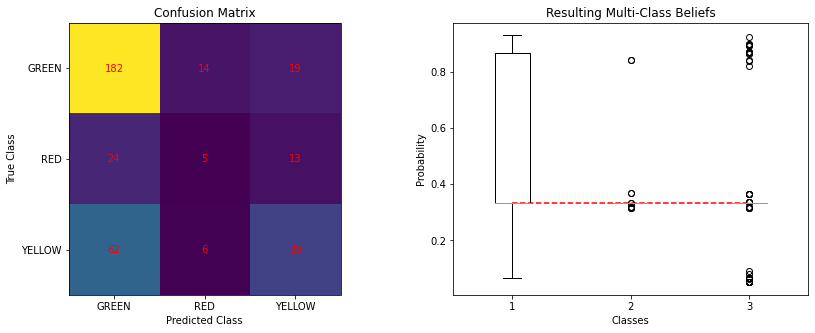

In [96]:
# Evaluation Metrics
# Get y_true vs y_pred for test set
y_true, y_pred = hf.get_labels(initial, X_test, beliefs, column=cn)

# Classification metrics
yp_clf, classes = hf.class_metrics(y_true, y_pred, classes=usedNames, orig=classNames)

fig, axs = pl.create_subplots(1,2, figsize=[14,5])
# Confusion matrix
axs = pl.confusion_matrix(axs, y_true, yp_clf, classes)
  
# Cross entropy / Confidence metrics
if nClasses == 2: axs = pl.cross_entropy_metrics(axs, y_true, y_pred[:,1].reshape(-1,1), classes)
else: axs[1] = pl.cross_entropy_multiclass(axs[1], y_true, y_pred)

pl.show_plot()

In [101]:
# Save figure
pl.save_plot(fig, 'results/Beirut_extraData_adj{}{}_ifg{}{}_cl{}_std{}'.format(str(adjacent),str(geoNeighbours),str(phase),str(neighbours),str(nClasses),str(stdTest)))

KeyError: 'RED'

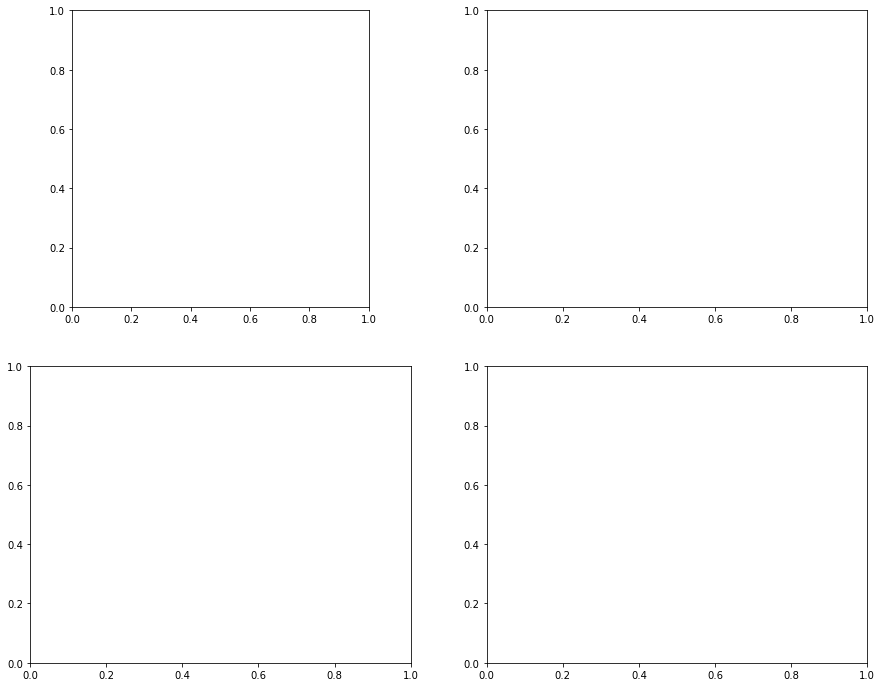

In [76]:
# Visualise spatial results
fig, axs = pl.create_subplots(2,2,figsize=[15,12])

prePlot = pl.belief_plot(nodes, axs[0,0], 'RED', normalise=False)
postPlot = pl.belief_plot(nodes, axs[0,1], beliefs, normalise=True)
assessPlt = joint.loc[joint.within(poly)].plot(ax=axs[1,0], column='decision',cmap='RdYlGn_r')
ifgPlot = (pl.cropped_ifg(ifgPreFile,testPoly)-pl.cropped_ifg(ifgPostFile,testPoly)).plot(ax=axs[1,1])
prePlot.set_title('A priori damage likelihood'), postPlot.set_title('Updated damage likelihood'), assessPlt.set_title('Damage Assessments')

pl.show_plot()